# ML Implementation using Amazon Sage Maker

Mapping train And Test Data in S3
Mapping The path of the models in S3

### Importing necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import boto3
# from botocore.exceptions import NoCredentialsError
import requests
import os
import io

### Load the data from S3

In [ ]:
# sagemaker_session = sagemaker.Session()

# # Read the CSV file from S3 and load it into a Pandas DataFrame
# s3_uri = f's3://bdae-dermatology/dermatology.csv'
# df = pd.read_csv(s3_uri)
df = pd.read_csv("dermatology.csv")


print(df.head())

   %erythema  scaling  definite borders  itching  koebner phenomenon  \
2          2        0                 3        0                   0   
3          3        3                 2        1                   0   
2          1        2                 3        1                   3   
2          2        2                 0        0                   0   
2          3        2                 2        2                   2   

   polygonal papules  follicular papules  oral mucosal involvement  \
2                  0                   0                         1   
3                  0                   0                         1   
2                  0                   3                         0   
2                  0                   0                         3   
2                  0                   2                         0   

   knee and elbow involvement  scalp involvement  ...  munro microabcess  \
2                           0                  0  ...                 

In [ ]:
df.columns

Index(['%erythema', 'scaling', 'definite borders', 'itching',
       'koebner phenomenon', 'polygonal papules', 'follicular papules',
       'oral mucosal involvement', 'knee and elbow involvement',
       'scalp involvement', 'family history (0 or 1)', 'Age (linear)',
       'melanin incontinence', 'eosinophils in the infiltrate',
       'PNL infiltrate', 'fibrosis of the papillary dermis', 'exocytosis',
       'acanthosis', 'hyperkeratosis', 'parakeratosis',
       'clubbing of the rete ridges', 'elongation of the rete ridges',
       'thinning of the suprapapillary epidermis', 'spongiform pustule',
       'munro microabcess', 'focal hypergranulosis',
       'disappearance of the granular layer',
       'vacuolisation and damage of basal layer', 'spongiosis',
       'saw-tooth appearance of retes', 'follicular horn plug',
       'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate',
       'band-like infiltrate'],
      dtype='object')

**Let's implement the random forest model to find the important features which are affecting the target variable.**

In [ ]:
X= df.drop('target',axis=1)
y=df['target']

KeyError: ignored

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_clf.fit(X, y)

print("Accuracy of the model",rf_clf.score(X,y))

NameError: ignored

In [ ]:
rf_clf.feature_importances_*100

array([ 0.        ,  0.29760886,  0.60034456,  0.20686712,  0.58648919,
        5.71823958,  0.36567317,  3.80896408,  1.57852088,  4.6254935 ,
        0.        ,  4.6764389 ,  0.        ,  1.27160338,  4.86821394,
        2.26670605,  0.01909808,  0.        ,  0.62508865, 13.27910539,
        6.78595554, 14.86241422,  0.        ,  1.91190678,  6.05427396,
        0.85759912,  7.37411373,  1.55530234,  7.86625404,  0.37334728,
        0.54915219,  0.01686259,  6.98269404,  0.01566885])

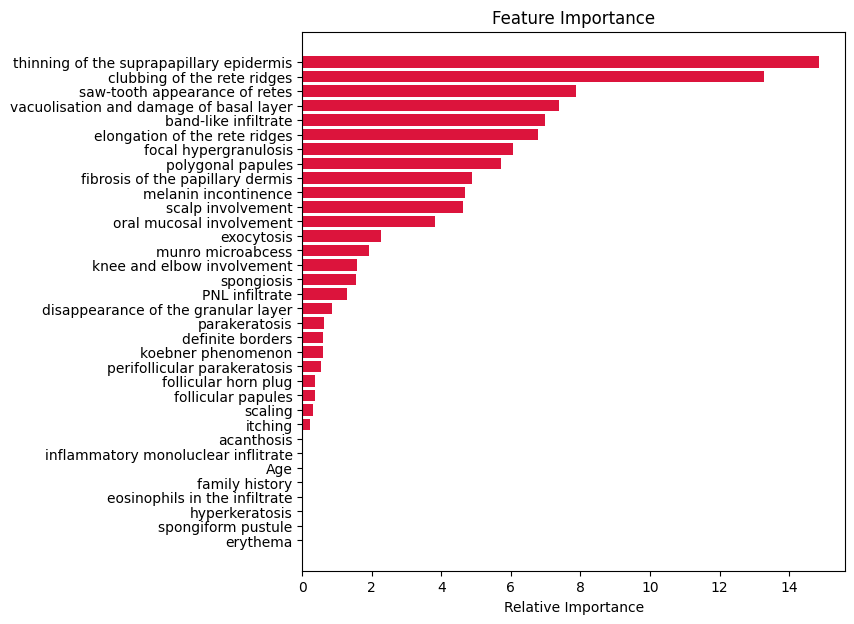

In [ ]:
# Calculating the feature importance
feature_importance = rf_clf.feature_importances_
feature_importance = 100.0*(feature_importance/np.sum(feature_importance))
# Displaying the relative feature importance by a horizontal bar chart
sorted_idx = np.argsort(feature_importance)
pos=np.arange(sorted_idx.shape[0])+0.5
plt.figure(figsize=(7, 7))
plt.title("Feature Importance")
plt.xlabel('Relative Importance')
plt.barh(pos, feature_importance[sorted_idx], color='crimson', align="center")
plt.yticks(pos,df.columns[:-1][sorted_idx])
plt.show()

We will take the important features till itching.

In [ ]:
df.columns

Index(['erythema', 'scaling', 'definite borders', 'itching',
       'koebner phenomenon', 'polygonal papules', 'follicular papules',
       'oral mucosal involvement', 'knee and elbow involvement',
       'scalp involvement', 'family history', 'melanin incontinence',
       'eosinophils in the infiltrate', 'PNL infiltrate',
       'fibrosis of the papillary dermis', 'exocytosis', 'acanthosis',
       'hyperkeratosis', 'parakeratosis', 'clubbing of the rete ridges',
       'elongation of the rete ridges',
       'thinning of the suprapapillary epidermis', 'spongiform pustule',
       'munro microabcess', 'focal hypergranulosis',
       'disappearance of the granular layer',
       'vacuolisation and damage of basal layer', 'spongiosis',
       'saw-tooth appearance of retes', 'follicular horn plug',
       'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate',
       'band-like infiltrate', 'Age', 'target'],
      dtype='object')

In [ ]:
important_features= df[['scaling', 'definite borders', 'itching',
       'koebner phenomenon', 'polygonal papules', 'follicular papules',
       'oral mucosal involvement', 'knee and elbow involvement',
       'scalp involvement', 'melanin incontinence',
        'PNL infiltrate',
       'fibrosis of the papillary dermis', 'exocytosis',
        'parakeratosis', 'clubbing of the rete ridges',
       'elongation of the rete ridges',
       'thinning of the suprapapillary epidermis',
       'munro microabcess', 'focal hypergranulosis',
       'disappearance of the granular layer',
       'vacuolisation and damage of basal layer', 'spongiosis',
       'saw-tooth appearance of retes', 'follicular horn plug',
       'perifollicular parakeratosis',
       'band-like infiltrate']]

y= df['target']

In [ ]:
_y_imbalance=y.value_counts()/len(y)*100
print("The percentage of each category in the target \n",_y_imbalance)

The percentage of each category in the target 
 1    30.601093
3    19.672131
2    16.666667
5    14.207650
4    13.387978
6     5.464481
Name: target, dtype: float64


In [ ]:
dict_y = { '1':int( _y_imbalance[1]),
          '3': int(_y_imbalance[2]),
          '2': int(_y_imbalance[3]),
          '5': int(_y_imbalance[4]),
          '4': int(_y_imbalance[5]),
          '6': int(_y_imbalance[6])

}

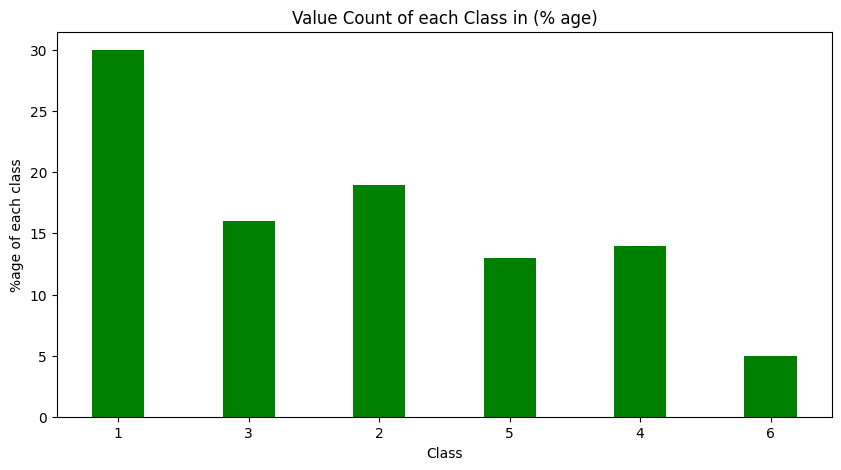

In [ ]:
type_ = list(dict_y.keys())
percentage = list(dict_y.values())
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(type_, percentage, color ='Green',
        width = 0.4)
plt.xlabel("Class")
plt.ylabel("%age of each class")
plt.title("Value Count of each Class in (% age)")
plt.show()

There is an imbalance in each type of target.

**SVM-LINEAR**

Accuracy on Train Data :  99%
Accuracy on Test Data :  98%
Precision on Train Data :  99%
Precision on Test Data :  98%
Recall on Train Data :  99%
Recall on Test Data :  98%
F1 on Train Data :  99%
F1 on Test Data :  98%


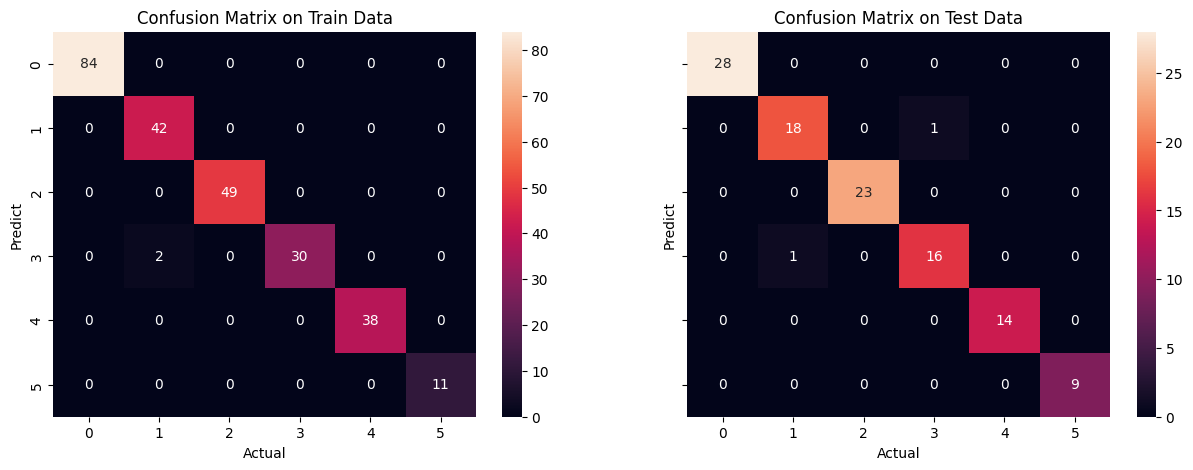

In [ ]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc # Importing 'roc_curve' and 'auc'
from sklearn.metrics import precision_score,recall_score #precision score

# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(important_features, y,test_size=0.30, random_state = 0)

# training a linear SVM classifier

svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train.values.ravel())

#predicting y_train and y_test
y_train_predict = svm_model_linear.predict(X_train)
y_test_predict = svm_model_linear.predict(X_test)

# model accuracy for X_train and X_test
accuracy_train = svm_model_linear.score(X_train, y_train)

print( "Accuracy on Train Data : ", str(int(accuracy_train*100)) +'%')

accuracy_test = svm_model_linear.score(X_test, y_test)

print( "Accuracy on Test Data : ", str(int(accuracy_test*100)) +'%' )

precision_train=precision_score(y_train,y_train_predict,zero_division='warn',average='micro')

# model precision for X_train and X_test
print( "Precision on Train Data : ", str(int(precision_train*100)) +'%' )

precision_test=precision_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Precision on Test Data : ", str(int(precision_test*100)) +'%' ,)

recall_train=recall_score(y_train,y_train_predict,zero_division='warn',average='micro')

# model recall for X_train and X_test

print( "Recall on Train Data : ", str(int(recall_train*100)) +'%' )

recall_test=recall_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Recall on Test Data : ", str(int(recall_test*100)) +'%' ,)

# model F-1 score for X_train and X_test
F1_score_train =f1_score(y_train, y_train_predict,zero_division='warn',average='micro')

print( "F1 on Train Data : ", str(int(F1_score_train*100)) +'%' )

F1_score_test =f1_score(y_test, y_test_predict,zero_division='warn',average='micro')

print( "F1 on Test Data : ", str(int(F1_score_test*100)) +'%' )

cm_train = confusion_matrix(y_train,y_train_predict )
cm_test = confusion_matrix(y_test,y_test_predict )

fig, axes = plt.subplots(1, 2,figsize=(15, 5), sharey=True)
sns.heatmap(cm_train,annot=True,ax=axes[0])
sns.heatmap(cm_test,annot=True,ax=axes[1])
axes[0].set_title("Confusion Matrix on Train Data")
axes[1].set_title("Confusion Matrix on Test Data")
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predict')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predict')
plt.show()





- In Confusion matrix, we can observe that target 1 is predicted as 3 for one data point in training dataset.

- In Confusion matrix, we can observe that target 1 is predicted as 3 for two data point in test dataset.

**KNN Classifier**

Accuracy on Train Data :  97%
Accuracy on Test Data :  97%
Precision on Train Data :  97%
Precision on Test Data :  97%
Recall on Train Data :  97%
Recall on Test Data :  97%
F1 on Train Data :  97%
F1 on Test Data :  97%


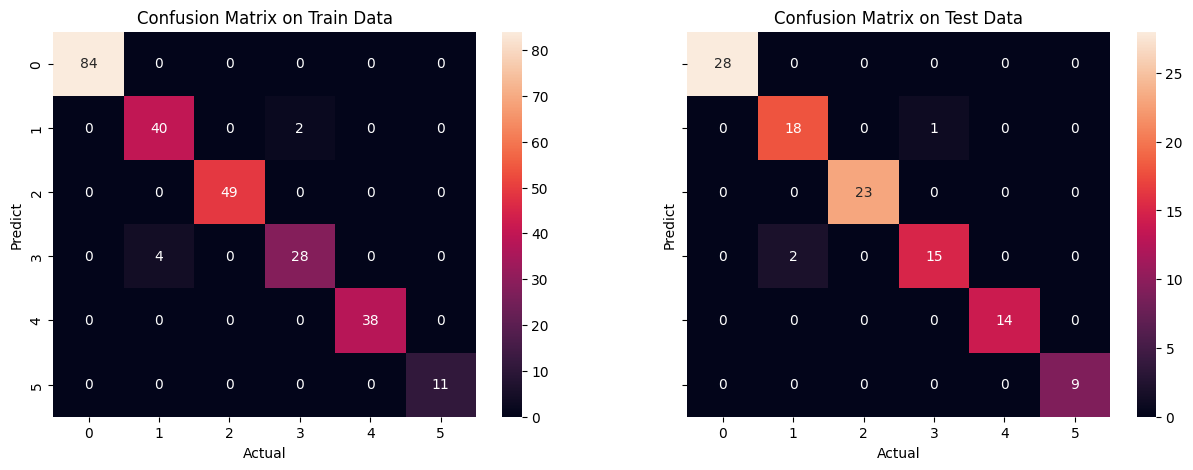

In [ ]:
from sklearn.neighbors import KNeighborsClassifier



# Train the KNN model using the training sets

KNN_model = KNeighborsClassifier(n_neighbors=6).fit(X_train, y_train.values.ravel()) #n_neighbors=6, we have 6 categories in the dataset

#predicting y_train and y_test
y_train_predict = KNN_model.predict(X_train)
y_test_predict = KNN_model.predict(X_test)

# model accuracy for X_train and X_test
accuracy_train = KNN_model.score(X_train, y_train)

print( "Accuracy on Train Data : ", str(int(accuracy_train*100)) +'%')

accuracy_test = KNN_model.score(X_test, y_test)

print( "Accuracy on Test Data : ", str(int(accuracy_test*100)) +'%' )

precision_train=precision_score(y_train,y_train_predict,zero_division='warn',average='micro')

# model precision for X_train and X_test

print( "Precision on Train Data : ", str(int(precision_train*100)) +'%' )

precision_test=precision_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Precision on Test Data : ", str(int(precision_test*100)) +'%')

# model recall for X_train and X_test

recall_train=recall_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Recall on Train Data : ", str(int(recall_train*100)) +'%' )

recall_test=recall_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Recall on Test Data : ", str(int(recall_test*100)) +'%' ,)

# model F-1 score for X_train and X_test
F1_score_train =f1_score(y_train, y_train_predict,zero_division='warn',average='micro')

print( "F1 on Train Data : ", str(int(F1_score_train*100)) +'%' )

F1_score_test =f1_score(y_test, y_test_predict,zero_division='warn',average='micro')

print( "F1 on Test Data : ", str(int(F1_score_test*100)) +'%' )

cm_train = confusion_matrix(y_train,y_train_predict )
cm_test = confusion_matrix(y_test,y_test_predict )

fig, axes = plt.subplots(1, 2,figsize=(15, 5), sharey=True)
sns.heatmap(cm_train,annot=True,ax=axes[0])
sns.heatmap(cm_test,annot=True,ax=axes[1])
axes[0].set_title("Confusion Matrix on Train Data")
axes[1].set_title("Confusion Matrix on Test Data")
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predict')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predict')
plt.show()


- In Confusion matrix, we can observe that target 1 is predicted as 3 for five data point in training dataset.

- In Confusion matrix, we can observe that target 1 is predicted as 3 for two data point in test dataset.

In [ ]:
# calculating the accuracy of models with different values of k
f_1_score = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat= knn.predict(X_test)
    f_1_score[i-1] = f1_score(y_test, yhat,average='micro')

print(f_1_score)

[0.96363636 0.97272727 0.97272727 0.97272727 0.97272727 0.97272727
 0.97272727 0.96363636 0.96363636 0.95454545 0.98181818 0.95454545
 0.96363636 0.95454545 0.95454545 0.94545455 0.94545455 0.92727273
 0.92727273 0.93636364]


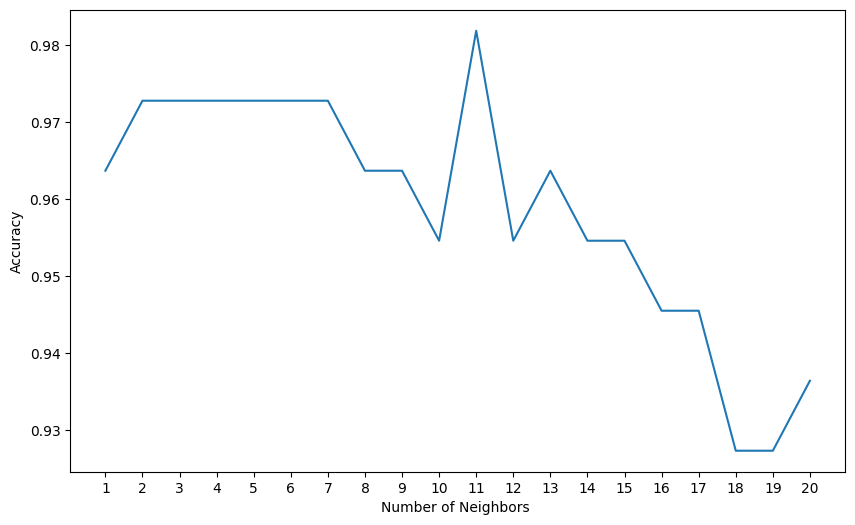

In [ ]:
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), f_1_score)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

When K=11, we got 98.18% on F1_Test_Score.

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
g_res = gs.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [ ]:
g_res.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')

**Tuning K values using Grid Search CV**

Accuracy on Train Data :  100%
Accuracy on Test Data :  96%
Precision on Train Data :  100%
Precision on Test Data :  96%
Recall on Train Data :  100%
Recall on Test Data :  96%
F1 on Train Data :  100%
F1 on Test Data :  96%


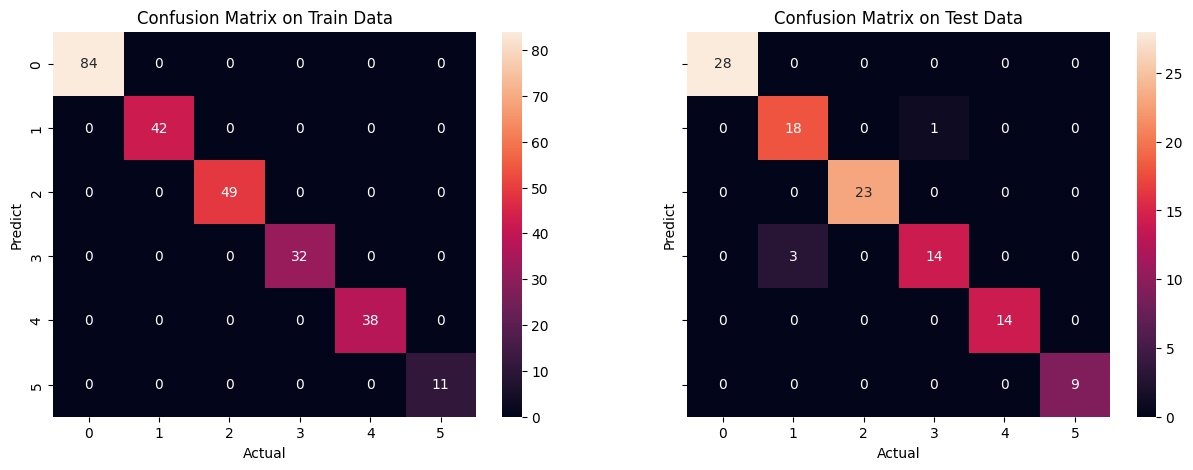

In [ ]:
from sklearn.neighbors import KNeighborsClassifier



# Train the KNN model using the training sets

KNN_model = KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance').fit(X_train, y_train.values.ravel()) #n_neighbors=6, we have 6 categories in the dataset

#predicting y_train and y_test
y_train_predict = KNN_model.predict(X_train)
y_test_predict = KNN_model.predict(X_test)

# model accuracy for X_train and X_test
accuracy_train = KNN_model.score(X_train, y_train)

print( "Accuracy on Train Data : ", str(int(accuracy_train*100)) +'%')

accuracy_test = KNN_model.score(X_test, y_test)

print( "Accuracy on Test Data : ", str(int(accuracy_test*100)) +'%' )

precision_train=precision_score(y_train,y_train_predict,zero_division='warn',average='micro')

# model precision for X_train and X_test

print( "Precision on Train Data : ", str(int(precision_train*100)) +'%' )

precision_test=precision_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Precision on Test Data : ", str(int(precision_test*100)) +'%')

# model recall for X_train and X_test

recall_train=recall_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Recall on Train Data : ", str(int(recall_train*100)) +'%' )

recall_test=recall_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Recall on Test Data : ", str(int(recall_test*100)) +'%' ,)

# model F-1 score for X_train and X_test
F1_score_train =f1_score(y_train, y_train_predict,zero_division='warn',average='micro')

print( "F1 on Train Data : ", str(int(F1_score_train*100)) +'%' )

F1_score_test =f1_score(y_test, y_test_predict,zero_division='warn',average='micro')

print( "F1 on Test Data : ", str(int(F1_score_test*100)) +'%' )

cm_train = confusion_matrix(y_train,y_train_predict )
cm_test = confusion_matrix(y_test,y_test_predict )

fig, axes = plt.subplots(1, 2,figsize=(15, 5), sharey=True)
sns.heatmap(cm_train,annot=True,ax=axes[0])
sns.heatmap(cm_test,annot=True,ax=axes[1])
axes[0].set_title("Confusion Matrix on Train Data")
axes[1].set_title("Confusion Matrix on Test Data")
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predict')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predict')
plt.show()


- In Confusion matrix, the model predicted everything correctly.

- In Confusion matrix, we can observe that target 1 is predicted as 3 for 3 data point in test dataset.

**CATEGORICAL NAIVE BAYES**

Accuracy on Train Data :  99%
Accuracy on Test Data :  97%
Precision on Train Data :  99%
Precision on Test Data :  97%
Recall on Train Data :  99%
Recall on Test Data :  97%
F1 on Train Data :  99%
F1 on Test Data :  97%


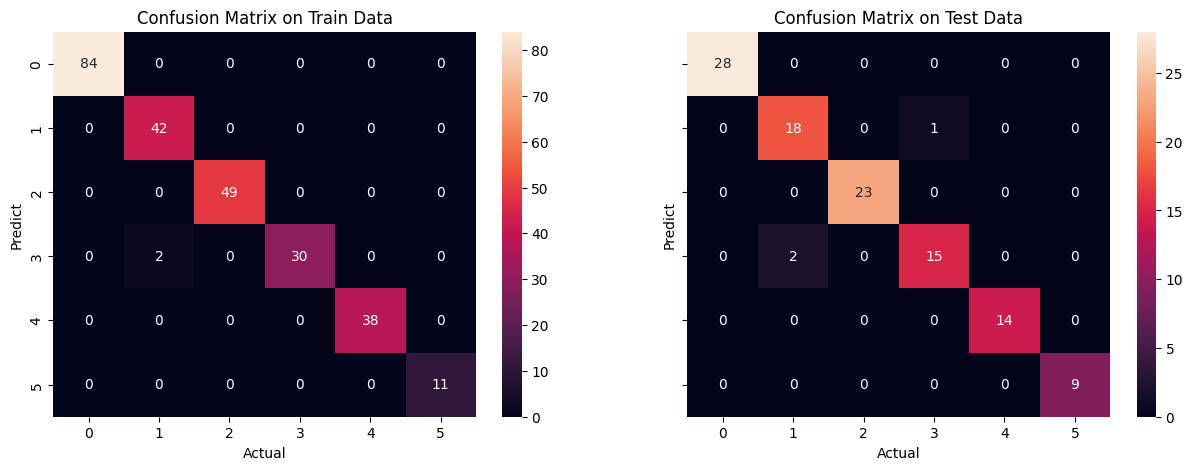

In [ ]:
from sklearn.naive_bayes import CategoricalNB
# Train the KNN model using the training sets

cnb_model = CategoricalNB().fit(X_train, y_train.values.ravel())

#predicting y_train and y_test
y_train_predict = cnb_model.predict(X_train)
y_test_predict = cnb_model.predict(X_test)

# model accuracy for X_train and X_test
accuracy_train = cnb_model.score(X_train, y_train)

print( "Accuracy on Train Data : ", str(int(accuracy_train*100)) +'%')

accuracy_test = cnb_model.score(X_test, y_test)

print( "Accuracy on Test Data : ", str(int(accuracy_test*100)) +'%' )

precision_train=precision_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Precision on Train Data : ", str(int(precision_train*100)) +'%' )

precision_test=precision_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Precision on Test Data : ", str(int(precision_test*100)) +'%' )
# model recall for X_train and X_test

recall_train=recall_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Recall on Train Data : ", str(int(recall_train*100)) +'%' )

recall_test=recall_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Recall on Test Data : ", str(int(recall_test*100)) +'%' ,)

# model F-1 score for X_train and X_test
F1_score_train =f1_score(y_train, y_train_predict,zero_division='warn',average='micro')

print( "F1 on Train Data : ", str(int(F1_score_train*100)) +'%' )

F1_score_test =f1_score(y_test, y_test_predict,zero_division='warn',average='micro')

print( "F1 on Test Data : ", str(int(F1_score_test*100)) +'%' )

cm_train = confusion_matrix(y_train,y_train_predict )
cm_test = confusion_matrix(y_test,y_test_predict )

fig, axes = plt.subplots(1, 2,figsize=(15, 5), sharey=True)
sns.heatmap(cm_train,annot=True,ax=axes[0])
sns.heatmap(cm_test,annot=True,ax=axes[1])
axes[0].set_title("Confusion Matrix on Train Data")
axes[1].set_title("Confusion Matrix on Test Data")
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predict')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predict')
plt.show()



- In Confusion matrix, we can observe that target 1 is predicted as 3 for 1 data point in training dataset.

- In Confusion matrix, we can observe that target 1 is predicted as 3 for 2 data point in test dataset.

**RANDOM-FOREST CLASSIFIER**

Accuracy on Train Data :  81%
Accuracy on Test Data :  73%
Precision on Train Data :  81%
Precision on Test Data :  73%
Recall on Train Data :  81%
Recall on Test Data :  73%
F1 on Train Data :  81%
F1 on Test Data :  73%


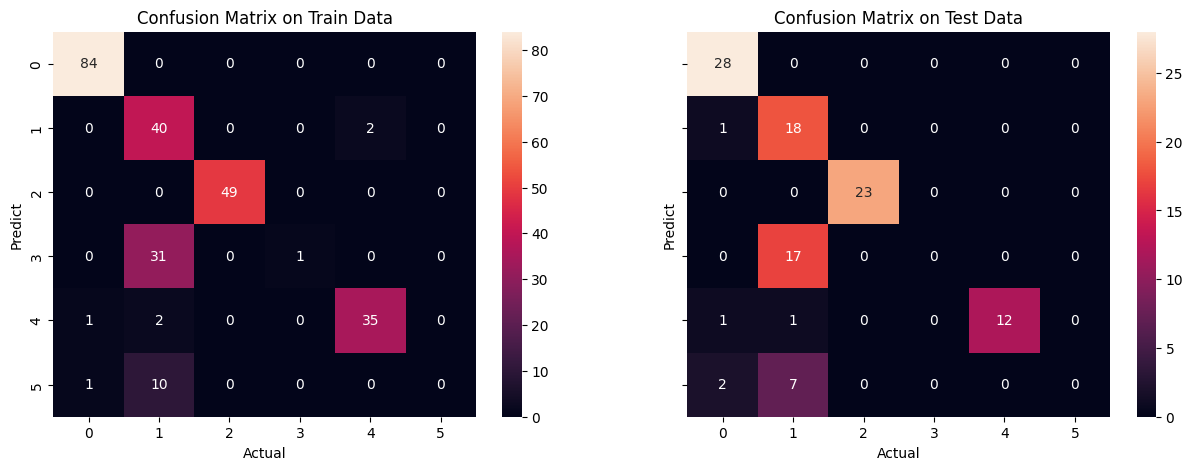

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train,y_train.ravel()) #random forest default values used in sklearn
#predicting y_train and y_test
y_train_predict = rf_clf.predict(X_train)
y_test_predict = rf_clf.predict(X_test)

# model accuracy for X_train and X_test
accuracy_train = rf_clf.score(X_train, y_train)

print( "Accuracy on Train Data : ", str(int(accuracy_train*100)) +'%')

accuracy_test = rf_clf.score(X_test, y_test)

print( "Accuracy on Test Data : ", str(int(accuracy_test*100)) +'%' )

precision_train=precision_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Precision on Train Data : ", str(int(precision_train*100)) +'%' )

precision_test=precision_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Precision on Test Data : ", str(int(precision_test*100)) +'%')
# model recall for X_train and X_test

recall_train=recall_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Recall on Train Data : ", str(int(recall_train*100)) +'%' )

recall_test=recall_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Recall on Test Data : ", str(int(recall_test*100)) +'%' ,)

# model F-1 score for X_train and X_test
F1_score_train =f1_score(y_train, y_train_predict,zero_division='warn',average='micro')

print( "F1 on Train Data : ", str(int(F1_score_train*100)) +'%' )

F1_score_test =f1_score(y_test, y_test_predict,zero_division='warn',average='micro')

print( "F1 on Test Data : ", str(int(F1_score_test*100)) +'%' )

cm_train = confusion_matrix(y_train,y_train_predict )
cm_test = confusion_matrix(y_test,y_test_predict )

fig, axes = plt.subplots(1, 2,figsize=(15, 5), sharey=True)
sns.heatmap(cm_train,annot=True,ax=axes[0])
sns.heatmap(cm_test,annot=True,ax=axes[1])
axes[0].set_title("Confusion Matrix on Train Data")
axes[1].set_title("Confusion Matrix on Test Data")
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predict')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predict')
plt.show()

- In Confusion matrix, we can observe that target 0 is predicted as 5 for 1 data point and target 1 is predicted as target 5 for 10 data point, target 1 is predicted as target 3 for 34 data points and target 1 is predicted as target 4 for 5 data points in the training dataset.

- In Confusion matrix, we can observe that target 0 is predicted as 5 for 2 data point, target 0 is predicted as target 5 for 1 data point, target 1 is predicted as target 5 for 7 data points, target 1 is precited as target 3 for 15 data points in test dataset.

Let's tune the model and try

**HYPERPARAMETER TUNING FOR RANDOM FOREST CLASSIFIER**

In [ ]:
import datetime as datetime
from sklearn.model_selection import GridSearchCV
## Define Grid
grid = {
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [18]
}
## show start time
print(datetime.datetime.now())
## Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv= 5)
CV_rfr.fit(X_train, y_train)
## show end time
print(datetime.datetime.now())

2023-12-06 22:32:56.459206
2023-12-06 22:35:01.371924


In [ ]:
CV_rfr.best_estimator_

RandomForestClassifier(max_depth=7, n_estimators=300, random_state=18)

Accuracy on Train Data :  98%
Accuracy on Test Data :  96%
Precision on Train Data :  98%
Precision on Test Data :  96%
Recall on Train Data :  98%
Recall on Test Data :  96%
F1 on Train Data :  98%
F1 on Test Data :  96%


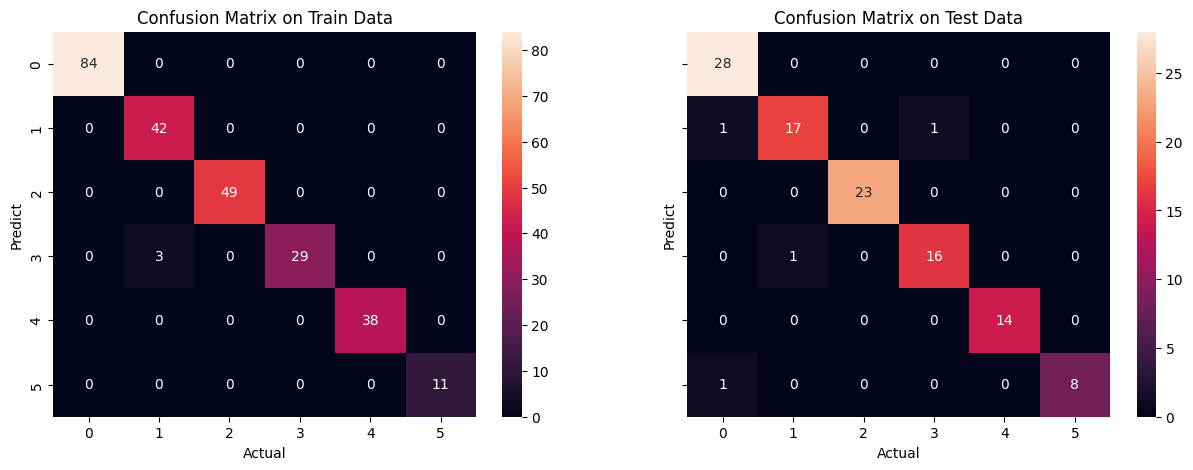

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=200,
                       random_state=18).fit(X_train,y_train.ravel()) #random forest default values used in sklearn
#predicting y_train and y_test
y_train_predict = rf_clf.predict(X_train)
y_test_predict = rf_clf.predict(X_test)

# model accuracy for X_train and X_test
accuracy_train = rf_clf.score(X_train, y_train)

print( "Accuracy on Train Data : ", str(int(accuracy_train*100)) +'%')

accuracy_test = rf_clf.score(X_test, y_test)

print( "Accuracy on Test Data : ", str(int(accuracy_test*100)) +'%' )

precision_train=precision_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Precision on Train Data : ", str(int(precision_train*100)) +'%' )

precision_test=precision_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Precision on Test Data : ", str(int(precision_test*100)) +'%')
# model recall for X_train and X_test

recall_train=recall_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Recall on Train Data : ", str(int(recall_train*100)) +'%' )

recall_test=recall_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Recall on Test Data : ", str(int(recall_test*100)) +'%' ,)

# model F-1 score for X_train and X_test
F1_score_train =f1_score(y_train, y_train_predict,zero_division='warn',average='micro')

print( "F1 on Train Data : ", str(int(F1_score_train*100)) +'%' )

F1_score_test =f1_score(y_test, y_test_predict,zero_division='warn',average='micro')

print( "F1 on Test Data : ", str(int(F1_score_test*100)) +'%' )

cm_train = confusion_matrix(y_train,y_train_predict )
cm_test = confusion_matrix(y_test,y_test_predict )

fig, axes = plt.subplots(1, 2,figsize=(15, 5), sharey=True)
sns.heatmap(cm_train,annot=True,ax=axes[0])
sns.heatmap(cm_test,annot=True,ax=axes[1])
axes[0].set_title("Confusion Matrix on Train Data")
axes[1].set_title("Confusion Matrix on Test Data")
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predict')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predict')
plt.show()

- In Confusion matrix, we can observe that target 1 is predicted as target 3 for 3 data point in training dataset.

- In Confusion matrix, we can observe that target 1 is predicted as 3 for 1 data point in test dataset.

** *italicized text*GRADIENT BOOSTING CLASSIFIER**

Accuracy on Train Data :  100%
Accuracy on Test Data :  97%
Precision on Train Data :  100%
Precision on Test Data :  97%
Recall on Train Data :  100%
Recall on Test Data :  97%
F1 on Train Data :  100%
F1 on Test Data :  97%


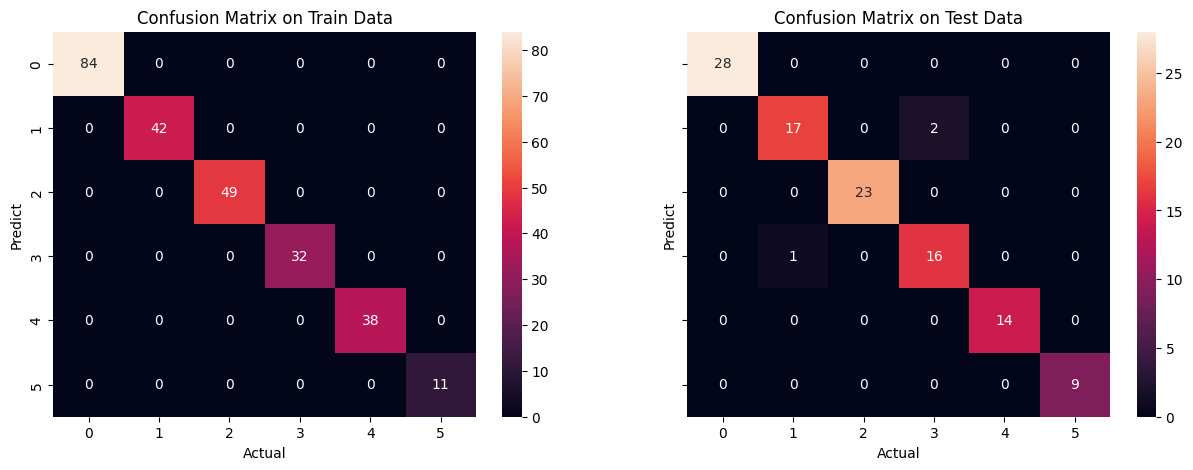

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_clf = GradientBoostingClassifier(max_depth=6, max_features='log2', n_estimators=200,
                       random_state=18).fit(X_train,y_train.ravel()) #random forest default values used in sklearn
#predicting y_train and y_test
y_train_predict = gbc_clf.predict(X_train)
y_test_predict = gbc_clf.predict(X_test)

# model accuracy for X_train and X_test
accuracy_train = gbc_clf.score(X_train, y_train)

print( "Accuracy on Train Data : ", str(int(accuracy_train*100)) +'%')

accuracy_test = gbc_clf.score(X_test, y_test)

print( "Accuracy on Test Data : ", str(int(accuracy_test*100)) +'%' )

precision_train=precision_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Precision on Train Data : ", str(int(precision_train*100)) +'%' )

precision_test=precision_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Precision on Test Data : ", str(int(precision_test*100)) +'%')
# model recall for X_train and X_test

recall_train=recall_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Recall on Train Data : ", str(int(recall_train*100)) +'%' )

recall_test=recall_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Recall on Test Data : ", str(int(recall_test*100)) +'%' ,)

# model F-1 score for X_train and X_test
F1_score_train =f1_score(y_train, y_train_predict,zero_division='warn',average='micro')

print( "F1 on Train Data : ", str(int(F1_score_train*100)) +'%' )

F1_score_test =f1_score(y_test, y_test_predict,zero_division='warn',average='micro')

print( "F1 on Test Data : ", str(int(F1_score_test*100)) +'%' )

cm_train = confusion_matrix(y_train,y_train_predict )
cm_test = confusion_matrix(y_test,y_test_predict )

fig, axes = plt.subplots(1, 2,figsize=(15, 5), sharey=True)
sns.heatmap(cm_train,annot=True,ax=axes[0])
sns.heatmap(cm_test,annot=True,ax=axes[1])
axes[0].set_title("Confusion Matrix on Train Data")
axes[1].set_title("Confusion Matrix on Test Data")
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predict')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predict')
plt.show()


- In Confusion matrix, we can observe the model have accurately predicted all the data points
- In Confusion matrix, we can observe that target 1 is predicted as 3 for one data point in test dataset and target 3 is predicted as 1 in test data set.

**HYPERPARAMETER TUNING FOR GRADIENT BOOSTING CLASSIFIER**

In [ ]:
param_grid = {'n_estimators':[200,300,400,500],
              'max_depth':[3,4,5,6,7], #range(5,16,2),
              'min_samples_split':[50,100], #range(200,1001,200),
              'learning_rate':[0.01,0.1,0.2],
              'random_state' : [18]}

## show start time
print(datetime.datetime.now())
## Grid Search function
CV_rfr = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv= 5)
CV_rfr.fit(X_train, y_train)
## show end time
print(datetime.datetime.now())

2023-12-06 22:35:06.949673


In [ ]:
CV_rfr.best_estimator_

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_clf = GradientBoostingClassifier(max_depth=4, min_samples_split=50, n_estimators=200,
                           random_state=18).fit(X_train,y_train.ravel()) #random forest default values used in sklearn
#predicting y_train and y_test
y_train_predict = gbc_clf.predict(X_train)
y_test_predict = gbc_clf.predict(X_test)

# model accuracy for X_train and X_test
accuracy_train = gbc_clf.score(X_train, y_train)

print( "Accuracy on Train Data : ", str(int(accuracy_train*100)) +'%')

accuracy_test = gbc_clf.score(X_test, y_test)

print( "Accuracy on Test Data : ", str(int(accuracy_test*100)) +'%' )

precision_train=precision_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Precision on Train Data : ", str(int(precision_train*100)) +'%' )

precision_test=precision_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Precision on Test Data : ", str(int(precision_test*100)) +'%')
# model recall for X_train and X_test

recall_train=recall_score(y_train,y_train_predict,zero_division='warn',average='micro')

print( "Recall on Train Data : ", str(int(recall_train*100)) +'%' )

recall_test=recall_score(y_test,y_test_predict,zero_division='warn',average='micro')

print( "Recall on Test Data : ", str(int(recall_test*100)) +'%' ,)

# model F-1 score for X_train and X_test
F1_score_train =f1_score(y_train, y_train_predict,zero_division='warn',average='micro')

print( "F1 on Train Data : ", str(int(F1_score_train*100)) +'%' )

F1_score_test =f1_score(y_test, y_test_predict,zero_division='warn',average='micro')

print( "F1 on Test Data : ", str(int(F1_score_test*100)) +'%' )

cm_train = confusion_matrix(y_train,y_train_predict )
cm_test = confusion_matrix(y_test,y_test_predict )

fig, axes = plt.subplots(1, 2,figsize=(15, 5), sharey=True)
sns.heatmap(cm_train,annot=True,ax=axes[0])
sns.heatmap(cm_test,annot=True,ax=axes[1])
axes[0].set_title("Confusion Matrix on Train Data")
axes[1].set_title("Confusion Matrix on Test Data")
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predict')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predict')
plt.show()


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
#'''''from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [ ]:

from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model Name", "F1-Train", "F1-Test"])

# Add rows
myTable.add_row(["SVM-Linear","98%","97%"])
myTable.add_row(["KNN","97%","96%"])
myTable.add_row(["KNN Tuned ","100%","97%"])
myTable.add_row(["Categorical Naive Bayes","99%","97%"])
myTable.add_row(["Random Forest","81%","71%"])
myTable.add_row(["Random Forest Tuned","98%","96%"])
myTable.add_row(["Gradient Boosting Classifier","100%","97%"])
myTable.add_row(["Gradient Boosting Classifier Tuned","100%","96%"])

print(myTable)

After the model experiementation,

- We got categorical naive bayes performed well on train and test dataset.